Copyright 2019 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

# The PrediNet architecture and experiment code

This is the core code used for the results presented in the paper
["An Explicitly Relational Neural Network Architecture"](https://arxiv.org/abs/1905.10307).

If this is the first time running the colab, run the cell below to install
TensorFlow 2.0 and Sonnet 2.0. You might be asked to re-start the session.

In [ ]:
!pip install "tensorflow-gpu>=2.0.0rc0" --pre
!pip install "dm-sonnet>=2.0.0b0" --pre

## Implementing the PrediNet model

Let's first import the necessary dependencies: TensorFlow, numpy, matplotlib,
and files for uploading our datasets.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
from google.colab import files

## Importing the training, validation and testing datasets

We now load smaller versions of the datasets, provided in this repository. Make
sure you download all dataset files for the target task:

*   `mini_3task_col_patts_pentos.npz`
*   `mini_3task_col_patts_hexos.npz`
*   `mini_3task_col_patts_stripes.npz`,

as well for the pre-training task:

*   `mini_between_pentos.npz`
*   `mini_between_hexos.npz`
*   `mini_between_stripes.npz`

from the repository to your local machine. You can select all six files for
uploading using `files.upload()`.

The files for the pentominoes datasets contain only 50,000 out of the 250,000
sample images and will be used here as the training set. The files for the
hexominoes and stripes datasets contain 5,000 samples and will be our held-out
sets. We use a downsampled version of the full datasets to avoid memory issues
when loading and running our experiments in Colab, but the full datasets can be
found
[here](https://console.cloud.google.com/storage/browser/relations-game-datasets).

In [ ]:
uploaded = files.upload()

## Dataset parameters

Now that the dataset files have been uploaded, we need to set some global
parameters:

*   **`RES`** - a scalar denoting the resolution of the images contained in the
    dataset. All the datasets provided have a resolution of 36 x 36 x 3.
*   **`NUM_CLASSES`** - a scalar denoting the number of classes, ie: the size of
    the label for the tasks. All the datasets provided have 2 classes
    (indicating True or False), with the exception of the `colour_and_or_shape`
    datasets which have 4 classes.
*   **`NUM_TASKS`** - a scalar denoting the number of tasks contained in each of
    the datasets. This can take a value between 1 and 5. Having a higher than
    required number of tasks will not lead to an error, so it is recommended to
    keep it to 5, which is the maximum number of tasks considered in any of the
    datasets.

Let's also define our task, training set, validation set and test set names:

*   **`TASKS`** - a string denoting the name of the tasks on which the network
    will be trained. Here, this will be `'3task_col_patts'`, in which each image
    contains a column of objects conforming to one of three possible patterns.
    Recognising each of the 3 possible patterns is a separate task.
*   **`PRE_TASKS`** - a string denoting the name of the pre-training tasks on
    which the network will be pre-trained. Here, this will be `'between'`, in
    which the (single) task is to determine whether the image contains three
    objects in a line comprising two identical objects either side of a third.
*   **`TRAINING_SET_NAME`** - a string denoting the name of the training set.
    Here we will use pentominoes (`'pentos'`) for training.
*   **`VALIDATION_SET_NAME`** - a string denoting the name of the validation
    set. Here we will use hexominoes (`'hexos'`) for validation.
*   **`TEST_SET_NAME`** - a string denoting the name of the test set. Here we
    will use striped squares (`'stripes'`) for testing.

Using the above tasks and datasets we will be able to produce figures that match
those in Figure 4 of the paper. You could, of course, train, validate and test
on any of the full datasets.

In [ ]:
RESOLUTION = 36
NUM_CLASSES = 2
NUM_TASKS = 5
TASKS = '3task_col_patts'
PRE_TASKS = 'between'
TRAINING_SET_NAME = 'pentos'
VALIDATION_SET_NAME = 'hexos'
TEST_SET_NAME = 'stripes'

## Retrieving a dataset and get a batch

We now need to define functions for loading a dataset and retrieving batches
from it, using the task and set names.

In [ ]:
def preprocess_dataset(images, labels, tasks):
  """Preprocesses a batch from the dataset.

  Args:
    images: An image of integer values in the range [0-255].
    labels: a numpy array of size (batch_size, 1). Contains an integer from 0
      to (NUM_CLASSES - 1) denoting the class of each image.
    tasks: a numpy array of size (batch_size, 1). Contains an integer from 0
      to (NUM_TASKS - 1) denoting the task from which each sample was drawn
      from.

  Returns:
    images: a tf.Tensor of size (batch_size, RESOLUTION, RESOLUTION, 3).
            Contains the normalised images.
    labels: a numpy array of size (batch_size, 1). Contains an integer from
      0 to (NUM_CLASSES - 1) denoting the class of each image.
    labels_1hot: a tf.Tensor of size (batch_size, NUM_CLASSES). Encodes the
      label for each sample into a 1-hot vector.
    tasks: a numpy array of size (batch_size, 1). Contains an integer from 0 to
      (NUM_TASKS - 1) denoting the task from which each sample was drawn from.
    tasks_1hot:  a tf.Tensor of size (batch_size, NUM_TASKS). Encodes the
      task for each sample into a 1-hot vector.
  """

  images = tf.divide(tf.cast(images, tf.float32), 256.0)
  labels_1hot = tf.one_hot(tf.cast(tf.squeeze(labels), tf.int32), NUM_CLASSES)
  tasks_1hot = tf.one_hot(tf.cast(tf.squeeze(tasks), tf.int32), NUM_TASKS)

  return (images, labels, labels_1hot, tasks, tasks_1hot)


def get_dataset(task_name, set_name, batch_size):
  """Given a task and set name loads and creates a dataset iterator.

  Args:
    task_name: a string. The name of the task.
    set_name: a string. One of 'pentos', 'hexos', 'stripes'
    batch_size: a scalar (int). The required number of samples in each batch.

  Returns:
    dataset: a tf.Dataset for the multitask dataset, with preprocessing.
  """
  loader = np.load('mini_{}_{}.npz'.format(task_name, set_name), 'rb')
  images = loader['images']
  labels = loader['labels']
  tasks = loader['tasks']

  # Create at tf.Dataset from the numpy arrays.
  dataset = tf.data.Dataset.from_tensor_slices((images, labels, tasks))
  # Create a dataset with infinite iterations, a buffer of 1000 elements from
  # which to draw samples, and specify the batch size.
  dataset = dataset.repeat(-1).shuffle(1000).batch(batch_size)

  return dataset.map(preprocess_dataset)

## Visualising the images

Now we define a couple of useful functions for visualising the images from the
datasets.

In [ ]:
def show_image(image):
  """Plots an image from the dataset with the appropriate formating.

  Args:
    image: a numpy array or tf.Tensor of size (RESOLUTION, RESOLUTION, 3) from
      the dataset.
  """
  # Plot the image
  plt.imshow(image, interpolation='nearest')
  # Make the plot look nice
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  ax = plt.gca()
  ax.spines['bottom'].set_color('0.5')
  ax.spines['top'].set_color('0.5')
  ax.spines['left'].set_color('0.5')
  ax.spines['right'].set_color('0.5')


def visualise_dataset(dataset):
  """Plots and prints a 3 x 3 grid of sample images from the dataset.

  Args:
    dataset: a tf.Iterator object. Used to draw batches of data for
      visualisation.
  """
  # Retrieve a batch from the dataset iterator
  images, labels, _, tasks, _ = next(dataset)

  # Plot it
  plt.figure(figsize=(8, 8))
  for i in range(9):
    image = images[i, :, :, :]
    label = labels[i][0]
    task = tasks[i][0]
    plt.subplot(3, 3, i + 1)
    show_image(image)
    if label:
      plt.title('Task id: {0}. Label: True'.format(task))
    else:
      plt.title('Task id: {0}. Label: False'.format(task))

  plt.show()

And let's use them to visualise the datasets we have loaded. You can play around
by changing the dataset or task.

In [ ]:
visualise_dataset(iter(get_dataset(TASKS, TRAINING_SET_NAME, 10)))

## Model configurations

Here we define some global parameters.

### Pre-processing convolutional layer

*   **`FILTER_SIZE`** - a scalar (int). The size of the filter convolution of
    the pre-processing convolutional layer.
*   **`STRIDE`** - a scalar (int). The stride of the convolutional layer.
*   **`NUM_CHANNELS`** - a scalar (int). The number of output channels of the
    pre-processing convolutional layer.
*   **`CONV_OUT_SIZE`** - a scalar (int). The resolution of the output of the
    pre-processing convolutional layer. i.e. the output of that layer will be of
    size (CONV_OUT_SIZE, CONV_OUT_SIZE, NUM_CHANNELS).

### PrediNet

*   **`HEADS_P`** - a scalar (int). The number of heads of the PrediNet.
*   **`RELATIONS_P`** - a scalar (int). The size of the relations vector that
    each of the PrediNet heads produces.
*   **`CENTRAL_OUTPUT_SIZE`** - a scalar (int). The output size of the central
    PrediNet module. It is the combined size of all heads.

In [ ]:
# Pre-processing convolutional layer parameters
FILTER_SIZE = 12
STRIDE = 6
NUM_CHANNELS = 32
CONV_OUT_SIZE = int((RESOLUTION - FILTER_SIZE) / STRIDE + 1)

# PrediNet module parameters
HEADS_P = 32
RELATIONS_P = 16
CENTRAL_OUTPUT_SIZE = HEADS_P * (RELATIONS_P + 4)

## Predinet model

We now need to define the PrediNet model, which is broken down into three
modules: 1. The input module composed of a single convolutional layer 2. The
central module composed of the PrediNet 3. The output module composed of a two
layer MLP

The model receives an image from the dataset and a 1-hot encoding of the task
id. The input module processes the image to produce a vector of features for
each of the patches in the input image. The central PrediNet module receives
these feature vectors and produces a key for each of them. Then, each of the
PrediNet heads produces two queries that match two of the keys (or mixtures of
them). A vector of relations is produced by each head using its corresponding
pair of selected feature vectors. The relations produced by all heads are then
put together in a long vector, to which the 1-hot task id is appended. This is
then passed through the output module to produce a classification indicating
whether, or not, the objects in the image conform to the particular high-level
relation defined by the task id. For more details about the network architecture
and the tasks, see the [PrediNet paper](https://arxiv.org/abs/1905.10307).

In [ ]:
class PrediNet4MultiTask(snt.Module):
  """PrediNet model for supervised learning."""

  def __init__(self,
               resolution,
               conv_out_size,
               filter_size,
               stride,
               channels,
               relations,
               heads,
               key_size,
               output_hidden_size,
               num_classes,
               num_tasks,
               name='PrediNet'):
    """Initialise the PrediNet model.

    Args:
      resolution: a scalar (int). Resolution of raw images.
      conv_out_size: a scalar (int). Downsampled image resolution obtained at
        the output of the convolutional layer.
      filter_size: a scalar (int). Filter size for the convnet.
      stride: a scalar (int). Stride size for the convnet.
      channels: a scalar (int). Number of channels of the convnet.
      relations: a scalar (int). Number of relations computed by each head.
      heads: a scalar (int). Number of PrediNet heads.
      key_size: a scalar (int). Size of the keys.
      output_hidden_size: a scalar (int). Size of hidden layer in output MLP.
      num_classes: a scalar (int). Number of classes in the output label.
      num_tasks: a scalar (int). Max number of possible tasks.
      name: a str. The name of the model.
    """
    super(PrediNet4MultiTask, self).__init__(name=name)
    self.model_desc = name
    self._resolution = resolution
    self._conv_out_size = conv_out_size
    self._filter_size = filter_size
    self._stride = stride
    self._channels = channels
    self._relations = relations
    self._heads = heads
    self._key_size = key_size
    self._output_hidden_size = output_hidden_size
    self._num_classes = num_classes

    self._weight_initializer = snt.initializers.TruncatedNormal(
        mean=0.0, stddev=0.1)
    self._bias_initializer = snt.initializers.Constant(0.1)

    # Feature co-ordinate matrix
    cols = tf.constant([[[x / float(self._conv_out_size)]
                         for x in range(self._conv_out_size)]
                        for _ in range(self._conv_out_size)])
    rows = tf.transpose(cols, [1, 0, 2])
    # Append feature co-ordinates
    self._locs = tf.reshape(
        tf.concat([cols, rows], 2),
        [self._conv_out_size * self._conv_out_size, 2])

    # Define all model components
    self.input_module = snt.Conv2D(
        output_channels=self._channels,
        kernel_shape=self._filter_size,
        stride=self._stride,
        padding='VALID',
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.get_keys = snt.Linear(
        output_size=self._key_size,
        with_bias=False,
        w_init=self._weight_initializer)
    self.get_query1 = snt.Linear(
        output_size=self._heads * self._key_size,
        with_bias=False,
        w_init=self._weight_initializer)
    self.get_query2 = snt.Linear(
        output_size=self._heads * self._key_size,
        with_bias=False,
        w_init=self._weight_initializer)
    self.embed_entities = snt.Linear(
        output_size=self._relations,
        with_bias=False,
        w_init=self._weight_initializer)
    self.output_hidden = snt.Linear(
        output_size=self._output_hidden_size,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.output = snt.Linear(
        output_size=self._num_classes,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)

  def _reinitialise_weight(self, submodule):
    """Re-initialise a weight variable."""
    submodule.w.assign(submodule.w_init(submodule.w.shape, submodule.w.dtype))

  def _reinitialise_bias(self, submodule):
    """Re-initialise a bias variable."""
    submodule.b.assign(submodule.b_init(submodule.b.shape, submodule.b.dtype))

  def reinitialise_input_module(self):
    """Re-initialise the weights of the input convnet."""
    self._reinitialise_weight(self.input_module)
    self._reinitialise_bias(self.input_module)

  def reinitialise_central_module(self):
    """Re-initialise the weights of the central PrediNet module."""
    self._reinitialise_weight(self.get_keys)
    self._reinitialise_weight(self.get_query1)
    self._reinitialise_weight(self.get_query2)
    self._reinitialise_weight(self.embed_entities)

  def reinitialise_output_module(self):
    """Re-initialise the weights of the output MLP."""
    self._reinitialise_weight(self.output_hidden)
    self._reinitialise_weight(self.output)
    self._reinitialise_bias(self.output_hidden)
    self._reinitialise_bias(self.output)

  def __call__(self, x, tasks, batch_size):
    """Applies model to image x yielding a label.

    Args:
      x: tensor. Input images of size (batch_size, RESOLUTION, RESOLUTION, 3).
      tasks: tensor. List of task sizes of size (batch_size, NUM_TASKS).
      batch_size: scalar (int). Batch size.

    Returns:
      output: tensor. Output of the model of size (batch_size, NUM_CLASSES).
    """
    features = tf.nn.relu(self.input_module(x))
    features = tf.reshape(features, [batch_size, -1, self._channels])

    # Append location
    locs = tf.tile(tf.expand_dims(self._locs, 0), [batch_size, 1, 1])
    features_locs = tf.concat([features, locs], 2)
    # (batch_size, conv_out_size*conv_out_size, channels+2)

    features_flat = snt.Flatten()(features_locs)
    # (batch_size, conv_out_size*conv_out_size*channels+2)

    # Keys
    keys = snt.BatchApply(self.get_keys)(features_locs)
    # (batch_size, conv_out_size*conv_out_size, key_size)

    keys = tf.tile(tf.expand_dims(keys, 1), [1, self._heads, 1, 1])
    # (batch_size, heads, conv_out_size*conv_out_size, key_size)

    # Queries
    query1 = self.get_query1(features_flat)
    # (batch_size, heads*key_size)
    query1 = tf.reshape(query1, [batch_size, self._heads, self._key_size])
    # (batch_size, heads, key_size)
    query1 = tf.expand_dims(query1, 2)
    # (batch_size, heads, 1, key_size)

    query2 = self.get_query2(features_flat)
    # (batch_size, heads*key_size)
    query2 = tf.reshape(query2, [batch_size, self._heads, self._key_size])
    # (batch_size, heads, key_size)
    query2 = tf.expand_dims(query2, 2)
    # (batch_size, heads, 1, key_size)

    # Attention weights
    keys_t = tf.transpose(keys, perm=[0, 1, 3, 2])
    # (batch_size, heads, key_size, conv_out_size*conv_out_size)
    att1 = tf.nn.softmax(tf.matmul(query1, keys_t))
    att2 = tf.nn.softmax(tf.matmul(query2, keys_t))
    # (batch_size, heads, 1, conv_out_size*conv_out_size)

    # Reshape features
    features_tiled = tf.tile(
        tf.expand_dims(features_locs, 1), [1, self._heads, 1, 1])
    # (batch_size, heads, conv_out_size*conv_out_size, channels+2)

    # Compute a pair of features using attention weights
    feature1 = tf.squeeze(tf.matmul(att1, features_tiled))
    feature2 = tf.squeeze(tf.matmul(att2, features_tiled))
    # (batch_size, heads, (channels+2))

    # Spatial embedding
    embedding1 = snt.BatchApply(self.embed_entities)(feature1)
    embedding2 = snt.BatchApply(self.embed_entities)(feature2)
    # (batch_size, heads, relations)

    # Comparator
    dx = tf.subtract(embedding1, embedding2)
    # (batch_size, heads, relations)

    # Positions
    pos1 = tf.slice(feature1, [0, 0, self._channels], [-1, -1, -1])
    pos2 = tf.slice(feature2, [0, 0, self._channels], [-1, -1, -1])
    # (batch_size, heads, 2)

    # Collect relations and concatenate positions
    relations = tf.concat([dx, pos1, pos2], 2)
    # (batch_size, heads, relations+4)
    relations = tf.reshape(relations,
                           [batch_size, self._heads * (self._relations + 4)])
    # (batch_size, heads*(relations+4))

    # Append task id
    relations_plus = tf.concat([relations, tasks], 1)

    # Apply output network
    hidden_activations = tf.nn.relu(self.output_hidden(relations_plus))
    output = self.output(hidden_activations)

    return output

## Baselines

If you wish to also train the other baselines, you can run the following code
cell, which will set the required parameters and define the baseline model
classes.

In [ ]:
# Baseline parameters

# 2-layer MLP baseline
# Fully connected hidden layer size
CENTRAL_HIDDEN_SIZE = 1024

# Relation net
# Relation net MLP layer 1 size
RN_HIDDEN_SIZE = 256

# Self-attention net
# Self-attention net number of heads - 32 will match those of PrediNet.
HEADS_SA = 32
# The required size of the Values produced by the model (per head), such that
# the self-attention output size equals that of the PrediNet.
VALUE_SIZE = int(CENTRAL_OUTPUT_SIZE / HEADS_SA)


# And below you can find the function definition.
class ConvNetMLP1L(snt.Module):
  """Convnet + Single layer baseline model for supervised learning.

  Input net = convnet
  Central net = Single linear layer
  Output net = 2-layer MLP
  """

  def __init__(self,
               resolution,
               conv_out_size,
               filter_size,
               stride,
               channels,
               central_output_size,
               output_hidden_size,
               num_classes,
               num_tasks,
               name='ConvNetMLP1L'):
    """Initialise the convnet/MLP model.

    Args:
      resolution: scalar. Resolution of raw images.
      conv_out_size: scalar. Downsampled resolution of the images.
      filter_size: scalar. Filter size for the convnet.
      stride: scalar. Stride size for the convnet.
      channels: scalar. Number of channels of the convnet.
      central_output_size: scalar. Output size of central MLP.
      output_hidden_size: a scalar (int). Size of hidden layer in output MLP.
      num_classes: scalar. Number of classes in the output label.
      num_tasks: scalar. Max number of possible tasks.
      name: a str. The name of the model.
    """
    super(ConvNetMLP1L, self).__init__(name=name)
    self.model_desc = '1-layer baseline'
    self._resolution = resolution
    self._conv_out_size = conv_out_size
    self._filter_size = filter_size
    self._stride = stride
    self._channels = channels
    self._central_output_size = central_output_size
    self._output_hidden_size = output_hidden_size
    self._num_classes = num_classes

    self._weight_initializer = snt.initializers.TruncatedNormal(
        mean=0.0, stddev=0.1)
    self._bias_initializer = snt.initializers.Constant(0.1)

    # Feature co-ordinate matrix
    cols = tf.constant([[[x / float(self._conv_out_size)]
                         for x in range(self._conv_out_size)]
                        for _ in range(self._conv_out_size)])
    rows = tf.transpose(cols, [1, 0, 2])
    # Append feature co-ordinates
    self._locs = tf.reshape(
        tf.concat([cols, rows], 2),
        [self._conv_out_size * self._conv_out_size, 2])

    # Define all model components
    self.input_module = snt.Conv2D(
        output_channels=self._channels,
        kernel_shape=self._filter_size,
        stride=self._stride,
        padding='VALID',
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.central_hidden = snt.Linear(
        output_size=self._central_output_size,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.output_hidden = snt.Linear(
        output_size=self._output_hidden_size,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.output = snt.Linear(
        output_size=self._num_classes,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)

  def _reinitialise_weight(self, submodule):
    """Re-initialise a weight variable."""
    submodule.w.assign(submodule.w_init(submodule.w.shape, submodule.w.dtype))

  def _reinitialise_bias(self, submodule):
    """Re-initialise a bias variable."""
    submodule.b.assign(submodule.b_init(submodule.b.shape, submodule.b.dtype))

  def reinitialise_input_module(self):
    """Re-initialise the weights of the input convnet."""
    self._reinitialise_weight(self.input_module)
    self._reinitialise_bias(self.input_module)

  def reinitialise_central_module(self):
    """Re-initialise the weights of the central hidden layer."""
    self._reinitialise_weight(self.central_hidden)
    self._reinitialise_bias(self.central_hidden)

  def reinitialise_output_module(self):
    """Re-initialise the weights of the output MLP."""
    self._reinitialise_weight(self.output_hidden)
    self._reinitialise_weight(self.output)
    self._reinitialise_bias(self.output_hidden)
    self._reinitialise_bias(self.output)

  def __call__(self, x, tasks, batch_size):
    """Applies model to image x yielding a label.

    Args:
      x: tensor. Input image.
      tasks: tensor. List of task sizes of length batch_size.
      batch_size: scalar. Batch size.

    Returns:
      output: tensor. Output of the model.
    """
    features = tf.nn.relu(self.input_module(x))
    features = tf.reshape(features, [batch_size, -1, self._channels])

    # Append location
    locs = tf.tile(tf.expand_dims(self._locs, 0), [batch_size, 1, 1])
    features_locs = tf.concat([features, locs], 2)
    # (batch_size, conv_out_size*conv_out_size, channels+2)

    features_flat = snt.Flatten()(features_locs)
    # (batch_size, conv_out_size*conv_out_size*(channels+2))

    # Fully connected layers
    central_activations = tf.nn.relu(self.central_hidden(features_flat))
    # (batch_size, central_output_size)

    # Append task id
    central_output = tf.concat([central_activations, tasks], 1)

    # Apply output network
    hidden_activations = tf.nn.relu(self.output_hidden(central_output))
    output = self.output(hidden_activations)

    return output


class ConvNetMLP2L(snt.Module):
  """Convnet/MLP baseline model for supervised learning.

  Input net = convnet
  Central net = 2-layer MLP
  Output net = 2-layer MLP
  """

  def __init__(self,
               resolution,
               conv_out_size,
               filter_size,
               stride,
               channels,
               central_hidden_size,
               central_output_size,
               output_hidden_size,
               num_classes,
               num_tasks,
               name='MLP2'):
    """Initialise the convnet/MLP model.

    Args:
      resolution: scalar. Resolution of raw images.
      conv_out_size: scalar. Downsampled resolution of the images.
      filter_size: scalar. Filter size for the convnet.
      stride: scalar. Stride size for the convnet.
      channels: scalar. Number of channels of the convnet.
      central_hidden_size: scalar. Hidden units size of central MLP.
      central_output_size: scalar. Output size of central MLP.
      output_hidden_size: a scalar (int). Size of hidden layer in output MLP.
      num_classes: scalar. Number of classes in the output label.
      num_tasks: scalar. Max number of possible tasks.
      name: a str. The name of the model.
    """
    super(ConvNetMLP2L, self).__init__(name=name)
    self.model_desc = '2-layer MLP baseline'
    self._resolution = resolution
    self._conv_out_size = conv_out_size
    self._filter_size = filter_size
    self._stride = stride
    self._channels = channels
    self._central_hidden_size = central_hidden_size
    self._central_output_size = central_output_size
    self._output_hidden_size = output_hidden_size
    self._num_classes = num_classes

    self._weight_initializer = snt.initializers.TruncatedNormal(
        mean=0.0, stddev=0.1)
    self._bias_initializer = snt.initializers.Constant(0.1)

    # Feature co-ordinate matrix
    cols = tf.constant([[[x / float(self._conv_out_size)]
                         for x in range(self._conv_out_size)]
                        for _ in range(self._conv_out_size)])
    rows = tf.transpose(cols, [1, 0, 2])
    # Append feature co-ordinates
    self._locs = tf.reshape(
        tf.concat([cols, rows], 2),
        [self._conv_out_size * self._conv_out_size, 2])

    # Define all model components
    self.input_module = snt.Conv2D(
        output_channels=self._channels,
        kernel_shape=self._filter_size,
        stride=self._stride,
        padding='VALID',
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.central_hidden = snt.Linear(
        output_size=self._central_hidden_size,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.central_output = snt.Linear(
        output_size=self._central_output_size,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.output_hidden = snt.Linear(
        output_size=self._output_hidden_size,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.output = snt.Linear(
        output_size=self._num_classes,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)

  def _reinitialise_weight(self, submodule):
    """Re-initialise a weight variable."""
    submodule.w.assign(submodule.w_init(submodule.w.shape, submodule.w.dtype))

  def _reinitialise_bias(self, submodule):
    """Re-initialise a bias variable."""
    submodule.b.assign(submodule.b_init(submodule.b.shape, submodule.b.dtype))

  def reinitialise_input_module(self):
    """Re-initialise the weights of the input convnet."""
    self._reinitialise_weight(self.input_module)
    self._reinitialise_bias(self.input_module)

  def reinitialise_central_module(self):
    """Re-initialise the weights of the central layers."""
    self._reinitialise_weight(self.central_hidden)
    self._reinitialise_bias(self.central_hidden)
    self._reinitialise_weight(self.central_output)
    self._reinitialise_bias(self.central_output)

  def reinitialise_output_module(self):
    """Re-initialise the weights of the output MLP."""
    self._reinitialise_weight(self.output_hidden)
    self._reinitialise_weight(self.output)
    self._reinitialise_bias(self.output_hidden)
    self._reinitialise_bias(self.output)

  def __call__(self, x, tasks, batch_size):
    """Applies model to image x yielding a label.

    Args:
      x: tensor. Input image.
      tasks: tensor. List of task sizes of length batch_size.
      batch_size: scalar. Batch size.

    Returns:
      output: tensor. Output of the model.
    """
    features = tf.nn.relu(self.input_module(x))
    features = tf.reshape(features, [batch_size, -1, self._channels])

    # Append location
    locs = tf.tile(tf.expand_dims(self._locs, 0), [batch_size, 1, 1])
    features_locs = tf.concat([features, locs], 2)
    # (batch_size, conv_out_size*conv_out_size, channels+2)

    features_flat = snt.Flatten()(features_locs)
    # (batch_size, conv_out_size*conv_out_size*(channels+2))

    # Fully connected layers
    central_activations = tf.nn.relu(self.central_hidden(features_flat))
    # (batch_size, central_hidden_size)
    central_out_activations = tf.nn.relu(
        self.central_output(central_activations))
    # (batch_size, central_output_size)

    # Append task id
    central_out_locs = tf.concat([central_out_activations, tasks], 1)

    # Apply output network
    hidden_activations = tf.nn.relu(self.output_hidden(central_out_locs))
    output = self.output(hidden_activations)

    return output


class RelationNet(snt.Module):
  """Relation net baseline model for supervised learning.

  Input net = convnet
  Central net = relation net
  Output net = 2-layer MLP

  Relation network taken from: Santoro, A., Raposo, D., Barrett,
  D. G., Malinowski, M., Pascanu, R., Battaglia, P., & Lillicrap, T.
  (2017). A simple neural network module for relational reasoning.
  In Advances in neural information processing systems (pp. 4967-4976).
  http://papers.nips.cc/paper/7082-a-simple-neural-network-module-for-relational-reasoning
  """

  def __init__(self,
               resolution,
               conv_out_size,
               filter_size,
               stride,
               channels,
               central_hidden_size,
               central_output_size,
               output_hidden_size,
               num_classes,
               num_tasks,
               name='RelationNet'):
    """Initialise the relation net model.

    Args:
      resolution: scalar. Resolution of raw images.
      conv_out_size: scalar. Downsampled resolution of the images.
      filter_size: scalar. Filter size for the convnet.
      stride: scalar. Stride size for the convnet.
      channels: scalar. Number of channels of the convnet.
      central_hidden_size: scalar. Hidden units size of Relation Net module.
      central_output_size: scalar. Output size of Relation Net module.
      output_hidden_size: a scalar (int). Size of hidden layer in output MLP.
      num_classes: scalar. Number of classes in the output label.
      num_tasks: scalar. Max number of possible tasks.
      name: a str. The name of the model.
    """
    super(RelationNet, self).__init__(name=name)
    self.model_desc = 'Relation net baseline'
    self._resolution = resolution
    self._conv_out_size = conv_out_size
    self._filter_size = filter_size
    self._stride = stride
    self._channels = channels
    self._central_hidden_size = central_hidden_size
    self._central_output_size = central_output_size
    self._output_hidden_size = output_hidden_size
    self._num_classes = num_classes

    self._weight_initializer = snt.initializers.TruncatedNormal(
        mean=0.0, stddev=0.1)
    self._bias_initializer = snt.initializers.Constant(0.1)

    # Feature co-ordinate matrix
    cols = tf.constant([[[x / float(self._conv_out_size)]
                         for x in range(self._conv_out_size)]
                        for _ in range(self._conv_out_size)])
    rows = tf.transpose(cols, [1, 0, 2])
    # Append feature co-ordinates
    self._locs = tf.reshape(
        tf.concat([cols, rows], 2),
        [self._conv_out_size * self._conv_out_size, 2])

    # Define all model components
    self.input_module = snt.Conv2D(
        output_channels=self._channels,
        kernel_shape=self._filter_size,
        stride=self._stride,
        padding='VALID',
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.central_hidden = snt.Linear(
        output_size=self._central_hidden_size,
        with_bias=False,
        w_init=self._weight_initializer)
    self.central_output = snt.Linear(
        output_size=self._central_output_size,
        with_bias=False,
        w_init=self._weight_initializer)
    self.output_hidden = snt.Linear(
        output_size=self._output_hidden_size,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.output = snt.Linear(
        output_size=self._num_classes,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)

  def _reinitialise_weight(self, submodule):
    """Re-initialise a weight variable."""
    submodule.w.assign(submodule.w_init(submodule.w.shape, submodule.w.dtype))

  def _reinitialise_bias(self, submodule):
    """Re-initialise a bias variable."""
    submodule.b.assign(submodule.b_init(submodule.b.shape, submodule.b.dtype))

  def reinitialise_input_module(self):
    """Re-initialise the weights of the input convnet."""
    self._reinitialise_weight(self.input_module)
    self._reinitialise_bias(self.input_module)

  def reinitialise_central_module(self):
    """Re-initialise the weights of the central layers."""
    self._reinitialise_weight(self.central_hidden)
    self._reinitialise_weight(self.central_output)

  def reinitialise_output_module(self):
    """Re-initialise the weights of the output MLP."""
    self._reinitialise_weight(self.output_hidden)
    self._reinitialise_weight(self.output)
    self._reinitialise_bias(self.output_hidden)
    self._reinitialise_bias(self.output)

  def __call__(self, x, tasks, batch_size):
    """Applies model to image x yielding a label.

    Args:
      x: tensor. Input image.
      tasks: tensor. List of task sizes of length batch_size.
      batch_size: scalar. Batch size.

    Returns:
      output: tensor. Output of the model.
    """
    features = tf.nn.relu(self.input_module(x))
    features = tf.reshape(features, [batch_size, -1, self._channels])

    # Append location
    locs = tf.tile(tf.expand_dims(self._locs, 0), [batch_size, 1, 1])
    features_locs = tf.concat([features, locs], 2)
    # (batch_size, conv_out_size*conv_out_size, channels+2)

    features_flat = tf.reshape(
        features_locs,
        [batch_size, (self._conv_out_size**2), self._channels + 2])
    # (batch_size, conv_out_size*conv_out_size, (channels+2))

    # Compute all possible pairs of features
    num_features = self._conv_out_size * self._conv_out_size
    indexes = tf.range(num_features)
    receiver_indexes = tf.tile(indexes, [num_features])
    sender_indexes = tf.reshape(
        tf.transpose(
            tf.reshape(receiver_indexes, [num_features, num_features])), [-1])
    receiver_objects = tf.gather(features_flat, receiver_indexes, axis=1)
    sender_objects = tf.gather(features_flat, sender_indexes, axis=1)
    object_pairs = tf.concat([sender_objects, receiver_objects], -1)
    # (batch_size, (conv_out_size*conv_out_size)^2, (channels+2)*2)

    # Compute "relations"
    central_activations = tf.nn.relu(
        snt.BatchApply(self.central_hidden)(object_pairs))
    # (batch_size, (conv_out_size*conv_out_size)^2, central_hidden_size)
    central_out_activations = tf.nn.relu(
        snt.BatchApply(self.central_output)(central_activations))
    # (batch_size, (conv_out_size*conv_out_size)^2, central_output_size)

    # Aggregate relations
    central_out_mean = tf.reduce_mean(central_out_activations, 1)
    # (batch_size, central_output_size)

    # Append task id
    central_out_locs = tf.concat([central_out_mean, tasks], 1)

    # Apply output network
    hidden_activations = tf.nn.relu(self.output_hidden(central_out_locs))
    output = self.output(hidden_activations)

    return output


class CombineValues(snt.Module):
  """Custom module for computing tensor products in SelfAttentionNet."""

  def __init__(self, heads, w_init=None):
    """Initialise the CombineValues module.

    Args:
      heads: scalar. Number of heads over which to combine the values.
      w_init: an initializer. A sonnet snt.initializers.
    """
    super(CombineValues, self).__init__(name='CombineValues')
    self._heads = heads
    self.w_init = w_init

  @snt.once
  def _initialize(self, inputs):
    num_features = inputs.shape[2]
    if self.w_init is None:
      self.w_init = snt.initializers.TruncatedNormal(mean=0.0, stddev=0.1)
    self.w = tf.Variable(
        self.w_init([self._heads, 1, num_features], inputs.dtype), name='w')

  def __call__(self, inputs):
    self._initialize(inputs)
    return tf.einsum('bhrv,har->bhav', inputs, self.w)


class SelfAttentionNet(snt.Module):
  """Self-attention network model for supervised learning.

  Input net = convnet
  Central net = self-attention module
  Output net = 2-layer MLP
  """

  def __init__(self,
               resolution,
               conv_out_size,
               filter_size,
               stride,
               channels,
               heads,
               key_size,
               value_size,
               output_hidden_size,
               num_classes,
               num_tasks,
               name='SelfAttention'):
    """Initialise the self-attention net model.

    Args:
      resolution: scalar. Resolution of raw images.
      conv_out_size: scalar. Downsampled resolution of the images.
      filter_size: scalar. Filter size for the convnet.
      stride: scalar. Stride size for the convnet.
      channels: scalar. Number of channels of the convnet.
      heads: scalar. Number of self-attention net heads.
      key_size: scalar. Size of the keys.
      value_size: scalar. Size of values in self-attention module.
      output_hidden_size: a scalar (int). Size of hidden layer in output MLP.
      num_classes: scalar. Number of classes in the output label.
      num_tasks: scalar. Max number of possible tasks.
      name: a str. The name of the model.
    """
    super(SelfAttentionNet, self).__init__(name=name)
    self.model_desc = 'Self-attention net baseline'
    self._resolution = resolution
    self._conv_out_size = conv_out_size
    self._filter_size = filter_size
    self._stride = stride
    self._channels = channels
    self._heads = heads
    self._key_size = key_size
    self._value_size = value_size
    self._output_hidden_size = output_hidden_size
    self._num_classes = num_classes

    self._weight_initializer = snt.initializers.TruncatedNormal(
        mean=0.0, stddev=0.1)
    self._bias_initializer = snt.initializers.Constant(0.1)

    # Feature co-ordinate matrix
    cols = tf.constant([[[x / float(self._conv_out_size)]
                         for x in range(self._conv_out_size)]
                        for _ in range(self._conv_out_size)])
    rows = tf.transpose(cols, [1, 0, 2])
    # Append feature co-ordinates
    self._locs = tf.reshape(
        tf.concat([cols, rows], 2),
        [self._conv_out_size * self._conv_out_size, 2])

    # Define all model components
    self.input_module = snt.Conv2D(
        output_channels=self._channels,
        kernel_shape=self._filter_size,
        stride=self._stride,
        padding='VALID',
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.get_keys = snt.Linear(
        output_size=self._heads * self._key_size,
        with_bias=False,
        w_init=self._weight_initializer)
    self.get_queries = snt.Linear(
        output_size=self._heads * self._key_size,
        with_bias=False,
        w_init=self._weight_initializer)
    self.get_values = snt.Linear(
        output_size=self._heads * self._value_size,
        with_bias=False,
        w_init=self._weight_initializer)
    self.central_output = CombineValues(
        heads=self._heads, w_init=self._weight_initializer)
    self.output_hidden = snt.Linear(
        output_size=self._output_hidden_size,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)
    self.output = snt.Linear(
        output_size=self._num_classes,
        w_init=self._weight_initializer,
        b_init=self._bias_initializer)

  def _reinitialise_weight(self, submodule):
    """Re-initialise a weight variable."""
    submodule.w.assign(submodule.w_init(submodule.w.shape, submodule.w.dtype))

  def _reinitialise_bias(self, submodule):
    """Re-initialise a bias variable."""
    submodule.b.assign(submodule.b_init(submodule.b.shape, submodule.b.dtype))

  def reinitialise_input_module(self):
    """Re-initialise the weights of the input convnet."""
    self._reinitialise_weight(self.input_module)
    self._reinitialise_bias(self.input_module)

  def reinitialise_central_module(self):
    """Re-initialise the weights of the central PrediNet module."""
    self._reinitialise_weight(self.get_keys)
    self._reinitialise_weight(self.get_queries)
    self._reinitialise_weight(self.get_values)
    self._reinitialise_weight(self.central_output)

  def reinitialise_output_module(self):
    """Re-initialise the weights of the output MLP."""
    self._reinitialise_weight(self.output_hidden)
    self._reinitialise_weight(self.output)
    self._reinitialise_bias(self.output_hidden)
    self._reinitialise_bias(self.output)

  def __call__(self, x, tasks, batch_size):
    """Applies model to image x yielding a label.

    Args:
      x: tensor. Input images of size (batch_size, RESOLUTION, RESOLUTION, 3).
      tasks: tensor. List of task sizes of size (batch_size, NUM_TASKS).
      batch_size: scalar (int). Batch size.

    Returns:
      output: tensor. Output of the model of size (batch_size, NUM_CLASSES).
    """
    features = tf.nn.relu(self.input_module(x))
    features = tf.reshape(features, [batch_size, -1, self._channels])

    # Append location
    locs = tf.tile(tf.expand_dims(self._locs, 0), [batch_size, 1, 1])
    features_locs = tf.concat([features, locs], 2)
    # (batch_size, conv_out_size*conv_out_size, channels+2)

    # Keys
    keys = snt.BatchApply(self.get_keys)(features_locs)
    #(batch_size, conv_out_size*conv_out_size, heads*key_size)
    keys = tf.reshape(keys, [
        batch_size, self._conv_out_size * self._conv_out_size, self._heads,
        self._key_size
    ])
    #(batch_size, conv_out_size*conv_out_size, heads, key_size)

    # Queries
    queries = snt.BatchApply(self.get_queries)(features_locs)
    #(batch_size, conv_out_size*conv_out_size, heads*key_size)
    queries = tf.reshape(queries, [
        batch_size, self._conv_out_size * self._conv_out_size, self._heads,
        self._key_size
    ])
    #(batch_size, conv_out_size*conv_out_size, heads, key_size)

    # Values
    values = snt.BatchApply(self.get_values)(features_locs)
    #(batch_size, conv_out_size*conv_out_size, heads*value_size)
    values = tf.reshape(values, [
        batch_size, self._conv_out_size * self._conv_out_size, self._heads,
        self._value_size
    ])
    #(batch_size, conv_out_size*conv_out_size, heads, values_size)

    # Attention weights
    queries_t = tf.transpose(queries, perm=[0, 2, 1, 3])
    # (batch_size, heads, conv_out_size*conv_out_size, key_size)
    keys_t = tf.transpose(keys, perm=[0, 2, 3, 1])
    # (batch_size, heads, key_size, conv_out_size*conv_out_size)
    att = tf.nn.softmax(tf.matmul(queries_t, keys_t))
    # (batch_size, heads, conv_out_size^2, conv_out_size^2)

    # Apply attention weights to values
    values_t = tf.transpose(values, perm=[0, 2, 1, 3])
    # (batch_size, heads, conv_out_size*conv_out_size, value_size)
    values_out = tf.matmul(att, values_t)
    # (batch_size, heads, conv_out_size*conv_out_size, value_size)

    # Compute self-attention head output
    central_out = snt.Flatten()(tf.squeeze(self.central_output(values_out)))
    # (batch_size, heads*value_size)

    # Append task id
    central_out_plus = tf.concat([central_out, tasks], 1)

    # Apply output network
    hidden_activations = tf.nn.relu(self.output_hidden(central_out_plus))
    output = self.output(hidden_activations)

    return output

## Training

We now define functions for calculating the accuracy, loss, and gradients of our
model, as well as the training function. The training function takes a model and
a task name, draws batches from the training set (pentos) to train, and from the
validation set (hexos) to report progress periodically. The model is trained
with a learning rate of `0.01` using the `GradientDescentOptimizer`.

In [ ]:
def accuracy(y, y_labels):
  """Returns the average accuracy between model predictions and labels.

  Args:
    y: a tensor (batch_size, NUM_CLASSES) containing the model predictions.
    y_labels: a tensor of size (batch_size, NUM_CLASSES) containing 1-hot
      embeddings of the labels.
  """
  correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_labels, 1))

  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def loss(y, y_labels):
  """Returns the cross entropy loss between the predictions and the labels.

  Args:
    y: a tensor (batch_size, NUM_CLASSES) containing the model predictions.
    y_labels: a tensor of size (batch_size, NUM_CLASSES) containing 1-hot
      embeddings of the labels.

  Returns:
    cross_entropy: A tensor containing the average cross entropy between the
      predictions and the model.
  """

  cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_labels))
  return cross_entropy


def grad(model, x, tasks, y_labels, batch_size, variable_list):
  """Compute the gradients of the loss wirht respect the the model parameters.

  Args:
    model: An instance of the model being trained.
    x: tensor. Input images of size (batch_size, RESOLUTION, RESOLUTION, 3).
    tasks: tensor. List of task sizes of size (batch_size, NUM_TASKS).
    y_labels: a tensor of size (batch_size, NUM_CLASSES) containing 1-hot
      embeddings of the labels.
    batch_size: scalar (int). The number of samples in the batch.
    variable_list: list. Contains all the variables to be updated.

  Returns:
    A list of Tensors containing the gradients for each of the variables in the
      variable_list with respect to the loss.
  """

  with tf.GradientTape() as tape:
    y = model(x=x, tasks=tasks, batch_size=batch_size)
    loss_value = loss(y, y_labels)
  return tape.gradient(loss_value, variable_list)


def train_model(model, task_name, variable_list, epsilon=0.01):
  """Trains the given model on the given dataset.

  Args:
    model: An instance of the model to be trained.
    task_name: string. The name of the task to train on.
    variable_list: list. Contains all the variables to be updated.
    epsilon: float. The early stopping threshold.

  Returns:
    A tuple containing the trained model and a list of accuracies during
    training.
  """

  print('Training {0} on {1}\n'.format(model.model_desc, TRAINING_SET_NAME))

  train_iterations = 100000
  train_batch_size = 10
  valid_batch_size = 250

  training_set = get_dataset(task_name, TRAINING_SET_NAME, train_batch_size)
  valid_set = iter(
      get_dataset(task_name, VALIDATION_SET_NAME, valid_batch_size))

  valid_data = next(valid_set)
  x_valid = valid_data[0]
  y_valid_labels = valid_data[2]
  tasks_valid = valid_data[4]

  optimizer = snt.optimizers.SGD(learning_rate=0.01)

  # Initial accuracy for reference.
  y_valid = model(x_valid, tasks_valid, valid_batch_size)
  acc = accuracy(y_valid, y_valid_labels)
  accuracies = [acc]
  print('Accuracy for batch 0 {:.3f}\n'.format(acc))

  converged = False
  for train_iter, train_data in enumerate(training_set.take(train_iterations)):

    if not converged:
      x_train = train_data[0]
      y_train_labels = train_data[2]
      tasks_train = train_data[4]
      grads = grad(model, x_train, tasks_train, y_train_labels,
                   train_batch_size, variable_list)
      optimizer.apply(grads, variable_list)

    # Compute accuracy
    if (train_iter + 1) % 500 == 0:
      valid_data = next(valid_set)
      x_valid = valid_data[0]
      y_valid_labels = valid_data[2]
      tasks_valid = valid_data[4]
      y_valid = model(x_valid, tasks_valid, valid_batch_size)
      acc = accuracy(y_valid, y_valid_labels)
      accuracies.append(acc)
      converged = (1 - acc) < epsilon

    if (train_iter + 1) % 20000 == 0:
      if not converged:
        print('Accuracy for batch {0} {1:.3f}\n'.format(train_iter + 1, acc))

  return (model, accuracies)

## Testing

Here we define a function that will test the accuracy of the trained model on a
given task, using the test set (stripes).

In [ ]:
def test_model(model, task_name):
  """Tests the given (trained) model on the given dataset and prints accuracy.

  Args:
    model: An instance of the trained model.
    task_name: string. The name of the task to train on.
  """

  print('Testing {0} on {1}'.format(model.model_desc, TEST_SET_NAME))

  batch_size = 250

  test_set = iter(get_dataset(task_name, TEST_SET_NAME, batch_size))
  test_data = next(test_set)

  x_test = test_data[0]
  y_test_labels = test_data[2]
  tasks_test = test_data[4]

  y_test = model(x_test, tasks_test, batch_size)

  test_accuracy = accuracy(y_test, y_test_labels)
  print('Accuracy for test set {:.3f}\n'.format(test_accuracy))

  # Show first 10 samples
  plt.subplots(figsize=(20, 5))

  for i in range(10):
    image = x_test[i]
    label = tf.argmax(y_test[i])
    task = tf.argmax(tasks_test[i])

    plt.subplot(1, 10, i + 1)
    show_image(image)
    plt.title('Task {0} label {1}'.format(task, label))

  plt.show()

## The Multi-task experiment

Now that all the necesary functions for running the experiment have been
defined, we will create our experiment. In order to assess the benefits of
pre-training, we will be conducting a four-stage experiment. These four stages
are:

1.  Train model A on target tasks from scratch
2.  Pre-train a new model B on pre-training tasks
3.  Retrain model B on target tasks with input and central network weights
    frozen, and output weights randomised
4.  Retrain on target tasks with input weights only frozen, and central and
    output weights randomised

What we expect to see is that during the third stage, the model can utilise the
representations learned from the pre-training task, and train on the original
task using fewer samples than when trained on the original task from scratch.

In [ ]:
def multitask_experiment(model_name, tasks, pre_tasks):
  """Carries out a four-stage experiment to assess benefits of pre-training.

  Args:
    model_name: string. Indicates which model is to be evaluated.
    tasks: string. The name of the target task(s) dataset.
    pre_tasks: string. The name of the pre-training tasks dataset.

  Returns:
    model. The final trained model.
    [accs1, accs2, accs3, accs4]. Lists of accuracies during training
    for each of the four stages of the experiment.
  """

  print('\n *** Starting experiment with {} model \n'.format(model_name))
  print('Target task(s): {}'.format(tasks))
  print('Curriculum task(s): {} \n'.format(pre_tasks))

  # 1. Train on target task(s) without pre-training
  print('\nTARGET TASK(S) WITHOUT PRE-TRAINING\n')

  if model_name == 'ConvNetMLP1L':
    model = ConvNetMLP1L(
        resolution=RESOLUTION,
        conv_out_size=CONV_OUT_SIZE,
        filter_size=FILTER_SIZE,
        stride=STRIDE,
        channels=NUM_CHANNELS,
        central_output_size=CENTRAL_OUTPUT_SIZE,
        output_hidden_size=8,
        num_classes=NUM_CLASSES,
        num_tasks=NUM_TASKS)
  elif model_name == 'ConvNetMLP2L':
    model = ConvNetMLP2L(
        resolution=RESOLUTION,
        conv_out_size=CONV_OUT_SIZE,
        filter_size=FILTER_SIZE,
        stride=STRIDE,
        channels=NUM_CHANNELS,
        central_hidden_size=CENTRAL_HIDDEN_SIZE,
        central_output_size=CENTRAL_OUTPUT_SIZE,
        output_hidden_size=8,
        num_classes=NUM_CLASSES,
        num_tasks=NUM_TASKS)
  elif model_name == 'RelationNet':
    model = RelationNet(
        resolution=RESOLUTION,
        conv_out_size=CONV_OUT_SIZE,
        filter_size=FILTER_SIZE,
        stride=STRIDE,
        channels=NUM_CHANNELS,
        central_hidden_size=RN_HIDDEN_SIZE,
        central_output_size=CENTRAL_OUTPUT_SIZE,
        output_hidden_size=8,
        num_classes=NUM_CLASSES,
        num_tasks=NUM_TASKS)
  elif model_name == 'SelfAttentionNet':
    model = SelfAttentionNet(
        resolution=RESOLUTION,
        conv_out_size=CONV_OUT_SIZE,
        filter_size=FILTER_SIZE,
        stride=STRIDE,
        channels=NUM_CHANNELS,
        heads=HEADS_SA,
        key_size=16,
        value_size=VALUE_SIZE,
        output_hidden_size=8,
        num_classes=NUM_CLASSES,
        num_tasks=NUM_TASKS)
  elif model_name == 'PrediNet':
    model = PrediNet4MultiTask(
        resolution=RESOLUTION,
        conv_out_size=CONV_OUT_SIZE,
        filter_size=FILTER_SIZE,
        stride=STRIDE,
        channels=NUM_CHANNELS,
        relations=RELATIONS_P,
        heads=HEADS_P,
        key_size=16,
        output_hidden_size=8,
        num_classes=NUM_CLASSES,
        num_tasks=NUM_TASKS)
  else:
    raise ValueError('Model {0} not recognised'.format(model_name))
  # Connect model
  _ = model(
      tf.zeros([10, RESOLUTION, RESOLUTION, 3]), tf.zeros([10, NUM_TASKS]), 10)
  variable_list = model.trainable_variables
  (model, accs1) = train_model(model, tasks, variable_list, epsilon=0.01)
  test_model(model, tasks)

  # 2. Pre-train on multi-task curriculum
  print('PRE-TRAINING CURRICULUM TASKS\n')

  if model_name == 'ConvNetMLP1L':
    model = ConvNetMLP1L(
        resolution=RESOLUTION,
        conv_out_size=CONV_OUT_SIZE,
        filter_size=FILTER_SIZE,
        stride=STRIDE,
        channels=NUM_CHANNELS,
        central_output_size=CENTRAL_OUTPUT_SIZE,
        output_hidden_size=8,
        num_classes=NUM_CLASSES,
        num_tasks=NUM_TASKS)
  elif model_name == 'ConvNetMLP2L':
    model = ConvNetMLP2L(
        resolution=RESOLUTION,
        conv_out_size=CONV_OUT_SIZE,
        filter_size=FILTER_SIZE,
        stride=STRIDE,
        channels=NUM_CHANNELS,
        central_hidden_size=CENTRAL_HIDDEN_SIZE,
        central_output_size=CENTRAL_OUTPUT_SIZE,
        output_hidden_size=8,
        num_classes=NUM_CLASSES,
        num_tasks=NUM_TASKS)
  elif model_name == 'RelationNet':
    model = RelationNet(
        resolution=RESOLUTION,
        conv_out_size=CONV_OUT_SIZE,
        filter_size=FILTER_SIZE,
        stride=STRIDE,
        channels=NUM_CHANNELS,
        central_hidden_size=RN_HIDDEN_SIZE,
        central_output_size=CENTRAL_OUTPUT_SIZE,
        output_hidden_size=8,
        num_classes=NUM_CLASSES,
        num_tasks=NUM_TASKS)
  elif model_name == 'SelfAttentionNet':
    model = SelfAttentionNet(
        resolution=RESOLUTION,
        conv_out_size=CONV_OUT_SIZE,
        filter_size=FILTER_SIZE,
        stride=STRIDE,
        channels=NUM_CHANNELS,
        heads=HEADS_SA,
        key_size=16,
        value_size=VALUE_SIZE,
        output_hidden_size=8,
        num_classes=NUM_CLASSES,
        num_tasks=NUM_TASKS)
  elif model_name == 'PrediNet':
    model = PrediNet4MultiTask(
        resolution=RESOLUTION,
        conv_out_size=CONV_OUT_SIZE,
        filter_size=FILTER_SIZE,
        stride=STRIDE,
        channels=NUM_CHANNELS,
        relations=RELATIONS_P,
        heads=HEADS_P,
        key_size=16,
        output_hidden_size=8,
        num_classes=NUM_CLASSES,
        num_tasks=NUM_TASKS)
  else:
    raise ValueError('Model {0} not recognised'.format(model_name))
  # Connect model
  _ = model(
      tf.zeros([10, RESOLUTION, RESOLUTION, 3]), tf.zeros([10, NUM_TASKS]), 10)
  variable_list = model.trainable_variables
  (model, accs2) = train_model(model, pre_tasks, variable_list, epsilon=0.01)
  test_model(model, pre_tasks)

  # Freeze some weights and reset others
  print('Freezing weights\n')
  variable_list = []  # freeze all weights

  # 3. Unfreeze output network weights and retrain on target task(s)
  print('TARGET TASK(S) AFTER PRE-TRAINING, INPUT & CENTRAL NETS FROZEN\n')
  # Reset output network weights
  model.reinitialise_output_module()
  # Unfreeze output network weights
  variable_list = variable_list + [
      model.output_hidden.w, model.output_hidden.b, model.output.w,
      model.output.b
  ]
  # Retrain model
  (model, accs3) = train_model(model, tasks, variable_list, epsilon=0.01)
  test_model(model, tasks)

  # 4. Unfreeze central network weights and retrain again
  print('TARGET TASK(S) AFTER PRE-TRAINING, INPUT NET ONLY FROZEN\n')
  # Reset output network weights
  model.reinitialise_output_module()
  # Reset central network weights
  model.reinitialise_central_module()
  # Unfreeze central network weights
  if model_name == 'ConvNetMLP1L':
    variable_list = variable_list + [
        model.central_hidden.w, model.central_hidden.b
    ]
  elif model_name == 'ConvNetMLP2L':
    variable_list = variable_list + [
        model.central_hidden.w, model.central_hidden.b, model.central_output.w,
        model.central_output.b
    ]
  elif model_name == 'RelationNet':
    variable_list = variable_list + [
        model.central_hidden.w, model.central_output.w
    ]
  elif model_name == 'SelfAttentionNet':
    variable_list = variable_list + [
        model.get_keys.w, model.get_queries.w, model.get_values.w,
        model.central_output.w
    ]
  elif model_name == 'PrediNet':
    variable_list = variable_list + [
        model.get_keys.w, model.get_query1.w, model.get_query2.w,
        model.embed_entities.w
    ]
  else:
    raise ValueError('Model {0} not recognised'.format(model_name))
  # Retrain model
  (model, accs4) = train_model(model, tasks, variable_list, epsilon=0.01)
  test_model(model, tasks)

  return (model, [accs1, accs2, accs3, accs4])


def plot_multitask_accuracies(model, accuracies):
  """Plots the accuracies from the experiments.

  Args:
    model: An instance of the trained model.
    accuracies: The list of accuracies returned by the experiment.
  """

  ipdp = 500  # iterations per data point

  # Plot everything
  plt.plot(np.arange(len(accuracies[0])) * ipdp, accuracies[0])
  plt.plot(np.arange(len(accuracies[1])) * ipdp, accuracies[1])
  plt.plot(np.arange(len(accuracies[2])) * ipdp, accuracies[2])
  plt.plot(np.arange(len(accuracies[3])) * ipdp, accuracies[3])

  # Add title, lables
  plt.title('{} with multi-task pre-training'.format(model.model_desc))
  plt.xlabel('Batches')
  plt.ylabel('Accuracy')
  plt.ylim((0.4, 1.0))
  plt.legend([
      'No pre-training', 'Curriculum tasks', 'Input & central net pre-trained',
      'Input net only pre-trained'
  ],
             loc='best')
  plt.grid(False)
  plt.show()

## Running the experiment

You can run the experiment with one of the following model names:

1.  **`'PrediNet'`** - Central module is the PrediNet.
2.  **`'ConvNetMLP1L'`** (baseline). Central module is a single fully-connected
    layer.
3.  **`'ConvNetMLP2L'`** (baseline). Central module is two fully-connected
    layers.
4.  **`'RelationNet'`** (baseline). Central module is a relation net
    [Santoro et al](http://papers.nips.cc/paper/7082-a-simple-neural-network-module-for-relational-reasoning).
5.  **`'SelfAttentionNet'`** (baseline). Central module is a self-attention
    network with the same number of heads as the PrediNet.

For each name, the appropriate central module will be invoked. The input and
output modules are the same for all of them.


 *** Starting experiment with PrediNet model 

Target task(s): 3task_col_patts
Curriculum task(s): between 


TARGET TASK(S) WITHOUT PRE-TRAINING

Training PrediNet on pentos

Accuracy for batch 0 0.472

Accuracy for batch 20000 0.540

Accuracy for batch 40000 0.488

Accuracy for batch 60000 0.500

Accuracy for batch 80000 0.512

Accuracy for batch 100000 0.512

Testing PrediNet on stripes
Accuracy for test set 0.544



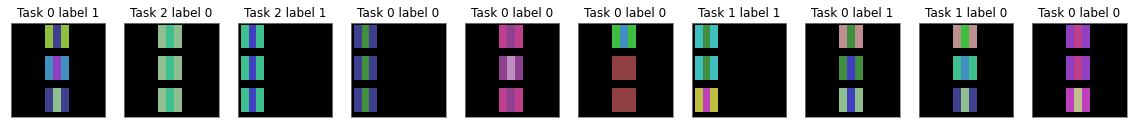

PRE-TRAINING CURRICULUM TASKS

Training PrediNet on pentos

Accuracy for batch 0 0.548

Accuracy for batch 20000 0.976

Accuracy for batch 40000 0.968

Accuracy for batch 60000 0.980

Accuracy for batch 80000 0.984

Testing PrediNet on stripes
Accuracy for test set 0.976



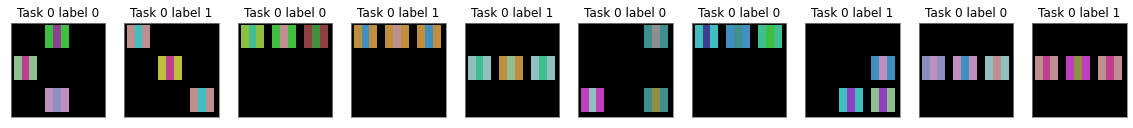

Freezing weights

TARGET TASK(S) AFTER PRE-TRAINING, INPUT & CENTRAL NETS FROZEN

Training PrediNet on pentos

Accuracy for batch 0 0.528

Accuracy for batch 20000 0.860

Accuracy for batch 40000 0.880

Accuracy for batch 60000 0.884

Accuracy for batch 80000 0.932

Accuracy for batch 100000 0.936

Testing PrediNet on stripes
Accuracy for test set 0.948



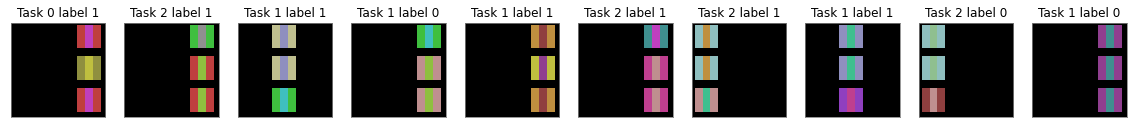

TARGET TASK(S) AFTER PRE-TRAINING, INPUT NET ONLY FROZEN

Training PrediNet on pentos

Accuracy for batch 0 0.496

Accuracy for batch 20000 0.592

Accuracy for batch 40000 0.684

Accuracy for batch 60000 0.876

Accuracy for batch 80000 0.940

Accuracy for batch 100000 0.948

Testing PrediNet on stripes
Accuracy for test set 0.900



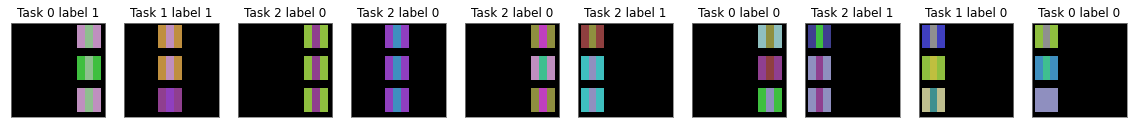

In [ ]:
(trained_model, acc_list) = multitask_experiment('PrediNet', TASKS, PRE_TASKS)

And finally let's print the learning curves. If the green curve increase above
chance much earlier than the blue one, there is evidence that the pre-training
task has led to the network learning reusable representations of the input.

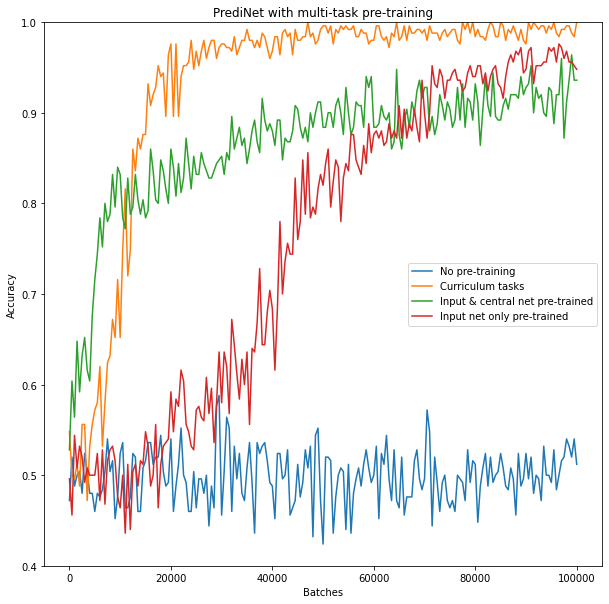

In [ ]:
plt.figure(figsize=(10, 10))
plot_multitask_accuracies(trained_model, acc_list)